## **RADI605: Modern Machine Learning**

### Assignment: Convolutional Neural Networks
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/CNN-Nodule-Classification)

Let's import the relevant libraries for this task. In this notebook, we primarily utilized PyTorch as our library to develop our deep learning model. 

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
import time
import os
import copy

from pathlib import Path
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

from PIL import Image
from torch.utils.data import WeightedRandomSampler

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings 
warnings.filterwarnings('ignore')

### Data Exploration: Baseline Characteristics

Prior to modeling, it is vital that we evaluate the characteristics of the datasets to conduct appropriate preprocessing tasks. The original dataset consists of 9796 images, distributed from 6877 training images, 1622 testing images, and 1297 validation. We checked the list of labels and have found out that 1690 training images does not have the corresponding labels. Therefore, **we will not include these images in our training dataset.** 

Future considerations may apply if the user wants to adopt a semi-supervised learning that uses both labeled and unlabeled datasets. In this task, however, will use a supervised learning for simplicity.

In [35]:
label_path = 'D:/nodule/data/labels/'

label = [pd.DataFrame(pd.read_csv(os.path.join(label_path, file), delim_whitespace = True)) for file in os.listdir(label_path)]
df = pd.concat(label, ignore_index = True)
df['types'] = [string.split('/') for string in df['image']]
df['types'] = [string[0] for string in df['types']]
df['image'] = [string.split('/') for string in df['image']]
df['image'] = [string[1][6:-4] for string in df['image']]

dict = {}
image_path = 'D:/nodule/data/images/'
folders = os.listdir(image_path)
images = ([os.listdir(os.path.join(image_path, folder)) for folder in folders])

test_images, train_images, valid_images  = images[0], images[1], images[2]

In [36]:
df[df['types'] == 'train'].head(5)

,image,label,types
1622,59270,0,train
1623,150277,0,train
1624,432208,0,train
1625,423122,0,train
1626,344581,0,train


We created a <code>NoduleDataset</code> class that represents the nodule images, including training, validation, and testing sets. These images can inherit the <code>Dataset</code> module and override the following methods:
- <code>__len__</code> function that returns the size of the dataset
- <code>__getitem__</code> function that supports the indexing of an $i$ image. 

We added a new function called <code>_load_data</code> that calls all the labels of the images. This function preprocess the label dataset and returns an array of the image and its binary label (i.e., either 0 for benign or 1 as malignant). The <code>NoduleDataset</code> class needs the following arguments: <code>data_path</code>, <code>image_path</code>, and <code>transforms</code>. 

Note: You may also access the <code>NoduleDataset</code> either the Python file <code>data_loader.py</code> or by importing it as <code>from data_loader import NoduleDataset</code>.

In [37]:
class NoduleDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, image_path, transforms = None):    
        ''' 
        Arguments:
             data_path (string): Directory of all the datasets
            image_path (string): Path to the image files. It should be either train, val, or test
            transform  (callable, option): Optional transfrom to be applied on an image for data augmentation
        '''
        self.transform  = transforms
        self.data_path  = data_path
        self.images_dir = data_path / 'images' / Path(image_path)

        if   image_path == 'train': 
            self.labels_dir = data_path / 'labels' / 'trainlabels.txt'
        elif image_path == 'val':
            self.labels_dir = data_path / 'labels' / 'vallabels.txt'
        elif image_path == 'test' :
            self.labels_dir = data_path / 'labels' / 'testlabels.txt'
        self.dataset = self._load_data(self.images_dir, self.labels_dir)

    def __getitem__(self, index):
        dataset  = self.dataset
        img_path = self.images_dir / dataset[index][0]
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        label = dataset[index][1]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset) 

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = os.path.basename(filename)
            label = int(label)
            data.append((filename, label))
        return data

One issue we can see from our image datasets is that the samples have small sizes and varying variation in terms of brightness and contrast. Most neural networks expect the images of a fixed, large size with varying degree of transformations. Hence, we need to write some processing code to perform image processing and make it suitable for CNN training. In addition, we need to use data augmentation techniques using transformation in our training process to artificially create new samples of our data, and use some constant preprocessing in the validation and testing case. This can provide generability in our datasets since augmentation acts as a regularizer and assists in managing the overfitting the data by exposing our CNN model to different versions of the images.  

In <code>PyTorch</code>, the widely-used image transformations are available in the <code>torchvision.transforms</code> module. They can be chained together using <code>Compose</code>. The appropriate transformations needed in our task and nodule image datasets are the following:
1. <code>Resize</code>: Resize the image shape. We checked some images and it has a size of <code>50 x 50</code> height and width. We need to assure that all images are of the same size. Therefore, resize is important.
2. <code>ToTensor</code>: We need to convert the image into PyTorch tensor shapes prior it into the CNN model. The image tensor shape should correspond to <code>(N, C, H, W)</code> representing the batch size, channels, height, and width, respectively.
3. <code>Normalize</code>: We need to normalize the image using the generally accepted values of mean $\mu = [0.485, 0.456, 0.406]$ and standard deviation $\sigma = [0.229, 0.224, 0.225]$ to convert the RGB channels of values [0, 255] into range [0, 1]. These $\mu$ and $\sigma$ were obtained by PyTorch using the <code>ImageNet</code> images. 
4. <code>RandomRotation</code>: This transformation rotates the image by a given angle. RandomRotation is a useful agumentation since it changes the angles that tissues appear in the given dataset during training. It can improve the generability of the dataset since some image collection processes vary. For instance, the images may only be collected with a nodule horizontally, but in reality, the nodule could be skewed in either direction. Therefore, random rotation can improve the model without collecting and (manually) labeling more data.
5. <code>RandomCrop</code>: This is a data augmentation technique where we create a random subset of the original image. Our primary task is to detect whether an image has a nodule. We have images when a nodule is visible but the nodules may not always complete in one frame, nor are they constantly in the same size. Therefore, RandomCrop can be a great choice as an augmentation technique in nodule classification task to recognize images with nodules, especially those nodules that are not always completely in frame. 
6. <code>RandomHorizontalFlip</code>: Using this transformation can help the model to learn the detection of nodule's features by identifying the left or right symmetry or even the lateralization of lesions. 
7. <code>RandomRotation</code>: Rotating the images by a certain degree can help the model learn to recognize nodules at different angles. 

As you can see in the code below, there are different transformations applied to training and validation datasets.
The <code>train_transform</code> has some random transforms, e.g., <code>RandomRotation</code>, which is fine for training but can yield different predictions for the same image in our testing dataset. It is thus preferred to use the non-random versions of the transformations for the validation to get consistent predictions.

In [38]:
train_transform =   transforms.Compose([
                    transforms.RandomRotation(10),      
                    transforms.RandomHorizontalFlip(),  
                    transforms.Resize((50, 50)), 
                    transforms.RandomCrop(32, padding = 2),         
                    transforms.CenterCrop(40),         
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

valid_transform =   transforms.Compose([
                    transforms.Resize((50, 50)),
                    transforms.CenterCrop(40),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

data_path  = Path('D:/nodule/data/')

train_dataset  = NoduleDataset(data_path, image_path = 'train', transforms = train_transform)
valid_dataset  = NoduleDataset(data_path, image_path = 'val',   transforms = valid_transform)
test_dataset   = NoduleDataset(data_path, image_path = 'test',  transforms = valid_transform)

Our initial analysis during data exploration is that the given dataset is imbalanced. That is, the number of images without nodules are higher than the images with nodules. In the training dataset, there are 4342 images with label 0 while only 845 images have label 1, accounting to 83.71\% and 16.29\%. The same case also exists in our validation dataset with with 1073 images without nodules while the remaining 224 have nodules. Imbalanced data brings challenges to feature correlation, class separation and evaluation, and mostly results in poor model performance.

The plot below shows an imbalanced dataset among training and validation sets.

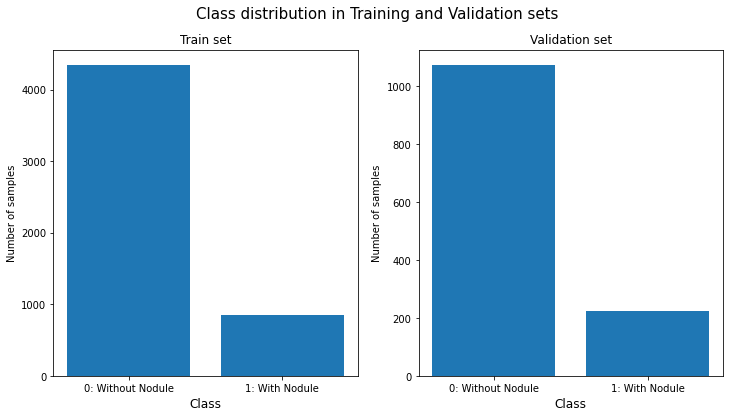

In [39]:
def check_imbalance(dataset):
    ''' 
    Counts the number of samples in every class for a given dataset
    Arguments:
        dataset 
    Returns: 
        tuple (value for class 0, value for class 1)
    '''
    classes = [label for _,   label in dataset]
    index_0 = len([idx   for idx, label in enumerate(classes) if label == 0])
    index_1 = len([idx   for idx, label in enumerate(classes) if label == 1])
    return index_0, index_1 

def plot_imbalance(train_dataset, valid_dataset):
    ''' 
    Creates the subplots and plots the class distribution
    '''
    class_count_train = check_imbalance(train_dataset)
    class_count_valid = check_imbalance(valid_dataset)

    fig, axs = plt.subplots(1, 2, figsize = (12, 6))
    fig.suptitle('Class distribution in Training and Validation sets', size = 15)
    labels = ['0: Without Nodule', '1: With Nodule']

    axs[0].bar(labels, class_count_train)
    axs[0].set_title('Train set')
    axs[0].set_xlabel('Class', size = 12)
    axs[0].set_ylabel('Number of samples')

    axs[1].bar(labels, class_count_valid)
    axs[1].set_title('Validation set')
    axs[1].set_xlabel('Class', size = 12)
    axs[1].set_ylabel('Number of samples')
    plt.show()


plot_imbalance(train_dataset, valid_dataset)

To rectify data imbalanced, we utilized <code>WeightedRandomSampler</code> for both training and validation sets. This function expects a <code>weight</code> tensor that assigns a weight to each image and ensures that each batch of images sees a proportional number of all classes. We created a function called <code>get_sampler</code> that uses WeightedRandomSampler and returns the appropriate sampling proportion of each class for every dataset. The sampler should consists of the weights for each target sample.

The datasets and samplers are then fed into the <code>DataLoader</code>. Using the PyTorch dataset and managing it with the DataLoader keeps our data manageable and helps to simplify our deep learning pipeline. The <code>Dataset</code> stores our data and the <code>DataLoader</code> can be used to iterate through the data. 

Our training and validation datasets consist of thousands of images. Our device may not be able to handle such large volumes of data during CNN training. Therefore, we use a <code>batch_size</code> of 32 as a hyperparameter to specify the number of samples being fed into the CNN model before the model parameters are updated. In this way, our device is not overloaded with work and our model can learn very well. In addition, smaller batch sizes of 32 allow for more efficient memory usage.

In [40]:
def get_sampler(dataset):
    '''  
    Description: Get weighted samples using Weighted Random Sampler
        Arguments:
            dataset: Any imbalanced dataset that requires oversampling
        Returns:
            dataset used with Weighted Random Sampler
    '''
    classes = [label for _,   label in dataset]
    index_0 = [idx   for idx, label in enumerate(classes) if label == 0]
    index_1 = [idx   for idx, label in enumerate(classes) if label == 1]
    weights = torch.zeros(len(index_0) + len(index_1))
    weights[index_0] = 1.0 / len(index_0)
    weights[index_1] = 1.0 / len(index_1)
    sampler = WeightedRandomSampler(weights = weights, num_samples = len(weights), replacement = True)
    return sampler

torch.manual_seed(42)
train_sampler = get_sampler(train_dataset)
valid_sampler = get_sampler(valid_dataset)

train_loader   = DataLoader(train_dataset, batch_size = 32, sampler = train_sampler)
valid_loader   = DataLoader(valid_dataset, batch_size = 32, sampler = valid_sampler)
test_loader    = DataLoader(test_dataset,  batch_size = 32, shuffle = False)

Let's display a batch of images to verify that the training loader selects nodule and without nodule images at random. We suppose <code>W</code> as **WITHOUT NODULE** with class label 0 while 1 for **WITH NODULE** <code>N</code>. As shown below, the number of <code>N</code> are almost the same with the number of <code>W</code> after using the <code>WeightedRandomSampling()</code>.

In [18]:
for images, labels in train_loader:
    break
class_names = ['W', 'N'] 
'''W: Without Nodule; N: Nodule'''
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

Label: [1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1]
Class:  N W N W N W N W N W N W N N W N N W W W W W N W W N W W W N N N


## Section 2. Proposed CNN Model

We created our proposed model in a class called <code>SamuelNet</code>. This class inherits from the <code>nn.Module</code> class, which is the base class for all neural network modules in PyTorch. The <code>SamuelNet</code> takes an input size of $50 \times 50$ tensors and our output represents the 2 possible digits - either 0 or 1. We used the AlexNet architecture as the baseline model for the nodule classification. However, we modified the baseline model in terms of the feature extractions and classifiers. 

We changed the AlexNet's feature extraction layers from five (5) to two (2) convolutions in order to reduce model complexity and avoid overfitting - given that our image datasets have $50 \times 50$ tensors. These convolution layers takes three kernel filters with 1 stride and a single padding. Each convolution is followed by a max-pooling layer to introduce local translation invariance and reduce spatial dimensions of the feature maps produced by the convolutional layer. The output of the convolution layers is fed to the ReLU function to avoid overfitting. We added Batch Normalization layers to each convolution layers to help <code>SamuelNet</code> learn faster and reduce the internal covariate shift, which can slow down the training process. The Batch Normalization can also improve the generalization of our network since it can reduce the dependence on the initial weight initialization and the choice of hyperparameters. Meanwhile, the <code>SamuelNet</code>'s classifier uses three fully-connected (FC) layers. However, we modified the third FC layer from the baseline model with 2 channels to classify 2 classes, instead of the regular 10 classes. We also added dropouts in our model to improve generalization and avoid any potential signs of overfitting. 

In [41]:
class SamuelNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)

        self.fc1 = nn.Linear(64 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32,   2)
        
        self.dropout = nn.Dropout(p = 0.2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
SamuelNet()

SamuelNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

By counting the number of parameters for each layer, we can evaluate the complexity and size of a model. For instance, the <code>SamuelNet</code> has 1.6M parameters, which is considerably smaller than the 60 million and 138 million parameters in the original AlexNet and VGG16 architectures, respectively. This information is useful for selecting the most appropriate model and designing an efficient architecture that balances effectiveness with computational and training requirements. If a model has too many parameters, it may overfit or require excessive resources, while too few parameters may not capture the complexity of the data adequately.

In [42]:
def count_parameters(model, print_all = True):
    ''' 
        Arguments:
            model: Deep learning to be analyzed in terms of number of parameters
            print_all: Print the number of parameters for each layer
        Returns:
            number of parameters
    '''
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if print_all:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

count_parameters(SamuelNet(), print_all = True)

     864
      32
   18432
      64
 1638400
     256
    8192
      32
      64
       2
      32
      32
      64
      64
________
 1666530


### Section 2.1 SamuelNet Model Training and Validation

Before we start the CNN model training, we created a function called <code>train</code> that simulates the whole training, validation, and testing process. This function requires the number of epochs <code>num_epochs</code>, CNN model <code>model</code>, the split datasets <code>train_loader, valid_loader</code>, and <code>test_loader</code>, optimization functions <code>optimizer, criterion, device</code>. The function <code>train</code> returns the losses, accuracy, metrics for training, validation, and testing. 

The <code>train</code> function primarily utilizes the <code>_train</code> and <code>_evals</code> to simulate the training and validation process, respectively. The testing set can be simulated to the <code>_evals</code> as well. Both <code>_train</code> and <code>_evals</code> returns the losses and accuracies for one epoch and the <code>train</code> simulates the whole process altogether. 

In [60]:
def binary_accuracy(preds, y):
    ''' 
    Arguments: 
        preds --> model output
        y     --> ground trutch
    Returns the accuracy of the model prediction
    '''
    rounded_preds = torch.round(preds)
    correct       = (rounded_preds == y).float()
    acc           = correct.sum() / len(correct)
    return acc

def get_metrics(prediction, label):
    ''' 
    Arguments: 
        predicrion --> model output
        label      --> ground trutch
    Returns classification metrics of the model prediction in a dictionary
    '''
    prediction  = prediction.cpu().detach().numpy()
    label = label.cpu().detach().numpy()
    
    tp = np.sum((prediction == 1) & (label == 1))
    tn = np.sum((prediction == 0) & (label == 0))
    fp = np.sum((prediction == 1) & (label == 0))
    fn = np.sum((prediction == 0) & (label == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    try:
        auc = roc_auc_score(label, prediction)
    except ValueError:
        auc = None
    fpr, tpr, _ = roc_curve(label, prediction)
    return {'sensitivity': sensitivity,
            'specificity': specificity,
            'auc': auc,
            'fpr': fpr,
            'tpr': tpr}

def epoch_time(start_time, end_time):
    ''' 
    Arguments: 
        start_time 
        end_time   
    Returns the elapsed minute and seconds of model training
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = True):
    ''' 
    Arguments:
        num_epochs: Number of epochs for model training and validation (usually 100 epochs)
        model: CNN model in PyTorch
        train_loader: Training   set (map-style dataset) implemented from DataLoader constructor
        valid_loader: Validation set (map-style dataset) implemented from DataLoader constructor
        test_loader:  Testing    set (map-style dataset) implemented from DataLoader constructor
        optimizer:  Optimization model for adjusting the model parameters to reduce model error in each training set
                    You may specify optimizer-specific options such as learning rate, weight decay, etc.
                    Usual values are: 
                        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
                        optimizer = optim.Adam([var1, var2], lr=0.0001)
        criterion: Loss function
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory

        accuracy (boolean): If True, prints training and validation losses and accuracies
                            Otherwise, only training and validation losses
    Returns:
        train_losses, valid_losses: (lists) loss values of the model training and validation, respectively
        train_accurs, valid_accurs  (lists) accuracy values of training and validation, respectively
        test_loss, test_accu: (float) loss and accuracy values of testing
        train_metric, valid_metric: (dictionary) metrics from the get_metrics(prediction, label) function
        best_epoch: (int) epoch number with the best model (i.e., lowest loss and highest accuracy)
        epoch_times: (list) of epoch_mins and epoch_secs
        test_metric: (dictionary) metrics using testing set
        test_predictions: (list) Predictions of the model on a testing set
        best_model: (model) Best model version from the best_epoch
    '''
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    train_metric, valid_metric = [], []

    epoch_times = []
    list_best_epochs = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_accu, train_metr    = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, valid_metr, _ = _evals(model, valid_loader, criterion, device)
        
        # if epoch % 10 == 0:
        if accuracy:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')
        else:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)} \t Validation Loss  {np.round(valid_loss, 5)}')
        
        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        train_metric.append(train_metr)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        valid_metric.append(valid_metr)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_metric, test_predictions  = _evals(best_model, test_loader, criterion, device)
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model

def _train(model, train_loader, optimizer, criterion, device):
    ''' 
    Description: _train is used for every one epoch
    Arguments:
        model: CNN model and should be instantiated to the device location (i.e., 'cpu' or 'cuda')
        train_loader: Training dataset loaded in PyTorch's DataLoader 
        optimizer: Optimizing function to reduce the loss (usually Adam) 
        criterion: Loss function to evaluate the prediction and target at one epoch
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory
    Returns:
        epoch_train_loss (float): Training loss at one epoch
        epoch_train_accu (float): Training accuracy at one epoch
        metric (dictionary): Training metrics based on the function get_metrics()
    '''
    model.train()
    epoch_train_loss = 0
    epoch_train_accu = 0

    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, outputs = torch.max(outputs, 1)
        
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        accuracy = binary_accuracy(outputs, labels)
        metric   = get_metrics(outputs, labels)
        epoch_train_accu += accuracy.item()

    epoch_train_loss = epoch_train_loss / len(train_loader) 
    epoch_train_accu = epoch_train_accu / len(train_loader) 
    return epoch_train_loss, epoch_train_accu, metric

def _evals(model, valid_loader, criterion, device):
    ''' 
    Description: _evals is used for every one epoch for validation and testing
    Arguments:
        model: CNN model and should be instantiated to the device location (i.e., 'cpu' or 'cuda')
        valid_loader: Validation dataset loaded in PyTorch's DataLoader 
        optimizer: Optimizing function to reduce the loss (usually Adam), should be the same in _train 
        criterion: Loss function to evaluate the prediction and target at one epoch, should be the same in _train
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory
    Returns:
        epoch_valid_loss (float): Validation loss at one epoch
        epoch_valid_accu (float): Validation accuracy at one epoch
        metric (dictionary): Training metrics based on the function get_metrics()
    '''
    model.eval()
    epoch_valid_loss = 0
    epoch_valid_accu = 0

    all_predictions = []

    with torch.no_grad():
        for id, data in enumerate(valid_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, outputs = torch.max(outputs, 1)
            all_predictions.extend(outputs)

            epoch_valid_loss += loss.item()
            accuracy = binary_accuracy(outputs, labels)
            metric  = get_metrics(outputs, labels)
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accu = epoch_valid_accu / len(valid_loader)
    return epoch_valid_loss, epoch_valid_accu, metric, all_predictions

def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs):
    alpha = 0.3
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]
    
    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha * train_losses[i] + (1-alpha) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha * valid_losses[i] + (1-alpha) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha * train_accurs[i] + (1-alpha) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha * valid_accurs[i] + (1-alpha) * smoothed_valid_accurs[-1])
    
    smoothed_train_losses = train_losses
    smoothed_train_accurs = train_accurs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()

class EarlyStopping:
  def __init__(self, patience  = 1, delta = 0, path = 'checkpoint.pt'):
    self.patience = patience
    self.delta = delta
    self.path= path
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(model)
    elif val_loss > self.best_score:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True 
    else:
      self.best_score = val_loss
      self.save_checkpoint(model)
      self.counter = 0      

  def save_checkpoint(self, model):
     torch.save(model.state_dict(), self.path)

We utilized Cross Entropy Loss as our loss function and Adam algorithm as our model's optimizer. They are effective optimization techniques that can help the model converge faster and can achieve better accuracy. While binary cross entropy (BCE) is famous for binary classification tasks, BCE can sometimes lead to a biased gradient when the data is imbalanced. For instance, our nodule dataset only have ~20% WITH NODULE class while 80% are WITHOUT NODULE class, the BCE loss may prioritize the WITHOUT NODULE samples and give less weight to the WITH NODULE class. In such cases, using cross entropy can help balance the gradient and avoid bias towards the majority class. 

In [32]:
torch.manual_seed(101)
model_cnn = SamuelNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.66989   	 Accuracy: 0.59062 	 Validation Loss  0.56604 	 Accuracy: 0.67992
Epoch: 11 	 Training: Loss 0.55071   	 Accuracy: 0.70501 	 Validation Loss  0.50978 	 Accuracy: 0.74112
Epoch: 21 	 Training: Loss 0.50359   	 Accuracy: 0.7592 	 Validation Loss  0.64666 	 Accuracy: 0.72274
Epoch: 31 	 Training: Loss 0.43931   	 Accuracy: 0.79659 	 Validation Loss  0.45682 	 Accuracy: 0.79847
Epoch: 41 	 Training: Loss 0.37732   	 Accuracy: 0.838 	 Validation Loss  0.5802 	 Accuracy: 0.75197
Epoch: 51 	 Training: Loss 0.37036   	 Accuracy: 0.84164 	 Validation Loss  0.37165 	 Accuracy: 0.84868
Epoch: 61 	 Training: Loss 0.3457   	 Accuracy: 0.85219 	 Validation Loss  0.39765 	 Accuracy: 0.83469
Epoch: 71 	 Training: Loss 0.32589   	 Accuracy: 0.86394 	 Validation Loss  0.31326 	 Accuracy: 0.86984
Epoch: 81 	 Training: Loss 0.31866   	 Accuracy: 0.86599 	 Validation Loss  0.3074 	 Accuracy: 0.87585
Epoch: 91 	 Training: Loss 0.31688   	 Accuracy: 0.86778 	 Validation L

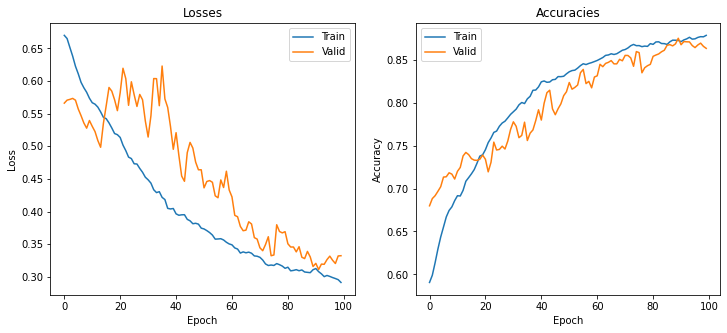

In [40]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

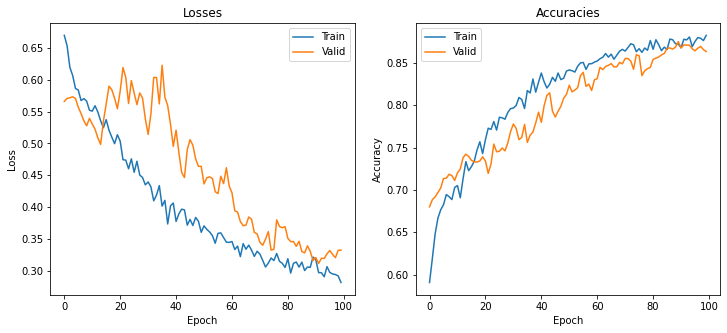

In [42]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

In [95]:
torch.manual_seed(101)
model_cnn = SamuelNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.66989   	 Accuracy: 0.59062 	 Validation Loss  0.56604 	 Accuracy: 0.67992
Epoch: 2 	 Training: Loss 0.65366   	 Accuracy: 0.61855 	 Validation Loss  0.58135 	 Accuracy: 0.70786
Epoch: 3 	 Training: Loss 0.61953   	 Accuracy: 0.64769 	 Validation Loss  0.57448 	 Accuracy: 0.69956
Epoch: 4 	 Training: Loss 0.60678   	 Accuracy: 0.6666 	 Validation Loss  0.57681 	 Accuracy: 0.70871
Epoch: 5 	 Training: Loss 0.58646   	 Accuracy: 0.67638 	 Validation Loss  0.56419 	 Accuracy: 0.71463
Epoch: 6 	 Training: Loss 0.58392   	 Accuracy: 0.68239 	 Validation Loss  0.52559 	 Accuracy: 0.73951
Epoch: 7 	 Training: Loss 0.56742   	 Accuracy: 0.6944 	 Validation Loss  0.52297 	 Accuracy: 0.71471
Epoch: 8 	 Training: Loss 0.5704   	 Accuracy: 0.69197 	 Validation Loss  0.50959 	 Accuracy: 0.7292
Epoch: 9 	 Training: Loss 0.56648   	 Accuracy: 0.68846 	 Validation Loss  0.50913 	 Accuracy: 0.7131
Epoch: 10 	 Training: Loss 0.55221   	 Accuracy: 0.70284 	 Validation Loss  0.

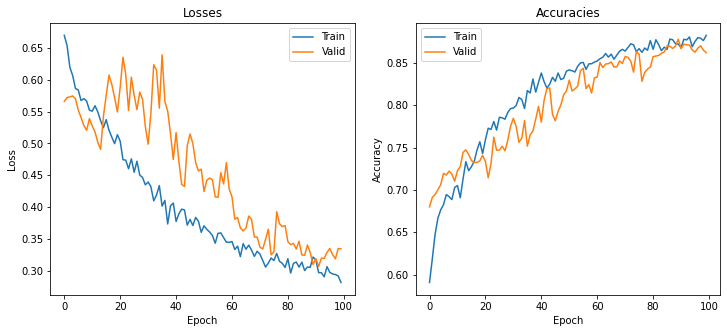

In [122]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

The plot above shows the (left) losses and (right) accuracy of the training (blue) and validation sets (orange). The plot above suggests that the model is likely to generalize well to new data and is unlikely to be overfitting nor underfitting. This indicates the <code>SamuelNet</code> has learned the underlying patterns of the data. Both the training and validation sets achieved an accuuracy greater than 85%, which can be a very good sign that our (first) model can classify images based on nodule detection. However, it is important to note that loss values and accuracy may not fully represent the model's performance, as it can vary based on the evaluation metrics and problem. Therefore, careful analysis and interpretation of the loss values, in the context of the specific problem and experimental setup, is crucial.

Both training and validation sets are converging to the local minima, but produces fluctuations. This suggests that the model is learning the underlying patterns of the images but can also experience some degree of variability in the training process. This may be due to the model complexity, size and variability of the dataset, or even the training and validation split. It may be necessary to optimize the model by adjusting various hyperparameters, regularization techniques, and optimization algorithms. Specifically, we may need to modify <code>SamuelNet</code> by determining if 1.6 million parameters may be too complex for the model to learn, use a different optimization algorithm, or even the loss function.

### Section 2.2 SamuelNet Inference and Testing

We saved our model in our local device for future use. The saved model can be used for testing datasets.

In [109]:
torch.save(model_cnn.state_dict(), '../models/SamNetwork.pt')

We evaluated our models based on the following classification metrics:
- **Sensitivity** measures the proportion of correctly classified **WITH NODULES** (<code>label: 1</code>) nodules among all **WITH NODULES** images (<code>label: 1</code>) in the dataset. High sensitivity means that the model is better at identifying **WITH NODULES** images (<code>label: 1</code>) and has fewer false negative predictions.
- **Specificity** measures the proportion of correctly classified benign nodules (<code>label: 0</code>) among all benign nodules (<code>label: 0</code>) in the dataset. High specificity means that the model is better at identifying benign nodules (<code>label: 0</code>) and has fewer false positive predictions.
-  **Precision** measures the proportion of correctly classified **WITH NODULES** images (<code>label: 1</code>) among **all nodules** that the model classified as **WITH NODULE**. High precision means that the model makes fewer false positive predictions, i.e., it is more precise in predicting **WITH NODULE** image.
- **Recall** measures the proportion of correctly classified **WITH NODULES** images among **WITH NODULES** in the dataset. High recall means that the model makes fewer false negative predictions, i.e., it correctly identifies most **WITH NODULES** images.

We also used <code>F1-score</code> over accuracy since accuracy alone may not be a good metric to evaluate the performance of the model with an imbalanced dataset, as it can be misleading. F1-score provides a more balanced measure of the model's performance in such cases. A high F1-score indicates that the model is performing well in terms of both precision and recall, meaning that it is making accurate predictions for both classes.


Let's try to test our model to our testing datasets. First, we analyzed the trained <code>SamuelNet</code> on a single batch of datasets (so that our device will not be overloaded). 

In [12]:
PATH = '../models/SamNetwork.pt'

model_cnn = SamuelNet()
model_svd = torch.load(PATH)
model_cnn.load_state_dict(model_svd)

def test_model(model, test_loader):
    ''' 
        Arguments:
            model: CNN model to be tested
            test_loader
        Returns:
            confusion matrix and classification report of the CNN model 
            using test_loader
    '''
    correct = 0
    total   = 0

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))
    print('Confusion Matrix:')
    print(confusion_matrix(labels, predicted))
    print('Classification Report:')
    print(classification_report(labels, predicted, target_names = ['Without nodule', 'With nodule']))
    return predicted, labels

predictions, labels = test_model(model_cnn, test_loader)

Test Accuracy: 87.42%
Confusion Matrix:
[[15  5]
 [ 0  2]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       0.29      1.00      0.44         2

    accuracy                           0.77        22
   macro avg       0.64      0.88      0.65        22
weighted avg       0.94      0.77      0.82        22



Results show that the model predicted 15 true positives and 2 true negatives, while misclassifying 5 false positives and 0 false negatives. The precision score for <code>Without Nodule</code> class is 1.0, suggesting that all samples classified as negative are actually negative. The precision score for <code>With Nodule</code> is only 0.29, indicating that out of all samples predicted to be positive, only 29% are actually positive. This suggests that the model has a high rate of false positives for <code>With nodule</code> images (class 1). 

The F1-score for the <code>without nodule</code> class is 0.86, while the F1-score for <code>with nodule</code> class is 0.44. The macro-average F1-score is 0.65, which suggests that the model has some room for improvement in terms of overall performance. The weighted-average F1-score is 0.82, which takes into account class imbalance and indicates that the model performs better on <code>without nodule</code> class. The model has a high sensitivity but low specificity. The model also has a high rate of false positives for class 1, indicating that it may need more training data or modifications to its architecture or hyperparameters to improve performance. 

Let's try to evaluate our model with more batches of testing datasets!

In [33]:
predictions, labels = test_model(model_cnn, test_loader)

Test Accuracy: 87.42%
Confusion Matrix:
[[88 17]
 [ 2 15]]
Classification Report:
                precision    recall  f1-score   support

Without nodule       0.98      0.84      0.90       105
   With nodule       0.47      0.88      0.61        17

      accuracy                           0.84       122
     macro avg       0.72      0.86      0.76       122
  weighted avg       0.91      0.84      0.86       122



Overall, the results suggest that the model performs well in detecting nodules, with perfect sensitivity and a relatively high AUC. However, the model has some room for improvement in terms of specificity, as it incorrectly identified 25% of the negative cases as positive. The AUC is 0.875, which suggests that the model performs well in distinguishing between positive and negative cases.

## Section 3. Using a Pre-trained CNN model

Torchvision has a repository of state-of-the-art (SOTA) models available through their module <code>torchvision.models</code>, such as AlexNet, VGG, ResNet, SqueezeNet, and many more. They have all been trained on the <code>ImageNet</code> dataset. Our nodule classification task is to reduce the output of the fully-connected layers from 1000 classes to just 2 classes. We can instantiate the model by calling its constructor <code>torchvision.models.alexnet(pretrained = True)</code>.

In this task, we utilized three pre-trained models: <code>AlexNet</code>, <code>VGG16</code>, <code>DenseNet-121</code>. However, we need to freeze the pre-trained weight and biases for some of these models to prevent them from being updated during fine-tuning or transfer learning on a new dataset. In addition, the parameters of both pretrained models are millions and might produce overfit results. We set <code>.requires_grad</code> to False so we don't backpropagate through them. We also need to modify the fully connected laters to produce a binary output. This section in the pre-trained model is labeled as a classifier.

**Our primary aim in using these pre-trained CNN models is to acquire insights on how to improve <code>SamuelNet</code>.** 

### Section 3.1. Pre-trained AlexNet Model for Binary Classification Task

We modified the first initial feature extraction methods of the pre-trained model after freezing its parameters. The kernel sizes for some convolutional and max pooling layers were dropped from 11 filters into 3 filters to adjust into the small input image. We also modified the fully connected layers to produce a binary output. Note that when we assign new layers, their parameters default to <code>model_alexnet.classifier[6].requires_grad = True</code>. The remaining number of parameters in AlexNet became 120,700. 

In this task, we hypothesize that having appropriate parameters for the CNN model should be a top concern - given that our datasets are small, including its sizes. Hence, <code>AlexNet</code>, with a remaining 120,770 parameters, may not do well in this nodule binary classification. 

In [56]:
model_alexnet = models.alexnet(pretrained = True).to(device)

for param in model_alexnet.parameters():
    param.requires_grad = False

torch.manual_seed(42)
model_alexnet.features[0] = torch.nn.Conv2d(3,  64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[2] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)
model_alexnet.features[3] = torch.nn.Conv2d(64, 192, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[5] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)

model_alexnet.classifier[6] = torch.nn.Linear(4096, 2)
model_alexnet.classifier[6].requires_grad = True

count_parameters(model_alexnet, print_all = False)

________
  120770


We utilized the same loss functions and optimizer from the SamuelNet. Unfortunately, the AlexNet training took 219 minutes (3.65 hours) to finish 100 epochs using a local device with **no GPU**.

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_alexnet.classifier.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_alexnet, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.68253   	 Accuracy: 0.59011 	 Validation Loss  0.66449 	 Accuracy: 0.60343
Epoch: 11 	 Training: Loss 0.68064   	 Accuracy: 0.59247 	 Validation Loss  0.661 	 Accuracy: 0.59599
Epoch: 21 	 Training: Loss 0.66259   	 Accuracy: 0.61145 	 Validation Loss  0.69256 	 Accuracy: 0.58303
Epoch: 31 	 Training: Loss 0.66178   	 Accuracy: 0.6158 	 Validation Loss  0.66242 	 Accuracy: 0.61411
Epoch: 41 	 Training: Loss 0.67061   	 Accuracy: 0.59867 	 Validation Loss  0.63382 	 Accuracy: 0.63908
Epoch: 51 	 Training: Loss 0.67643   	 Accuracy: 0.60723 	 Validation Loss  0.62586 	 Accuracy: 0.65567
Epoch: 61 	 Training: Loss 0.69516   	 Accuracy: 0.59024 	 Validation Loss  0.64936 	 Accuracy: 0.62478
Epoch: 71 	 Training: Loss 0.66857   	 Accuracy: 0.61433 	 Validation Loss  0.65249 	 Accuracy: 0.61621
Epoch: 81 	 Training: Loss 0.68478   	 Accuracy: 0.58979 	 Validation Loss  0.62911 	 Accuracy: 0.63069
Epoch: 91 	 Training: Loss 0.69612   	 Accuracy: 0.59516 	 Validatio

According to the results provided, the (frozen) AlexNet model is struggling to learn from the data, as both the training and validation accuracies are low and inconsistent over the epochs. During the initial epoch, the training accuracy was recorded at 0.59 and then increased to 0.62 at epoch 50, while the validation accuracy started at 0.60 and reached 0.66 at epoch 50. These outcomes suggest that the model is underfitting and lacks the capacity to learn from the data effectively. Additionally, the model is experiencing high loss values, which indicates an inability to reduce errors. The training loss initially stood at 0.68 and decreased to 0.67 after 90 epochs, while the validation loss increased from 0.66 to 0.72 after 90 epochs.

Instead of freezing all the pretrained parameters, we can try unfreezing some of the layers in the model and fine-tuning them on our nodule dataset. This may allow the AlexNet model to adapt better to our dataset and learn more relevant features.

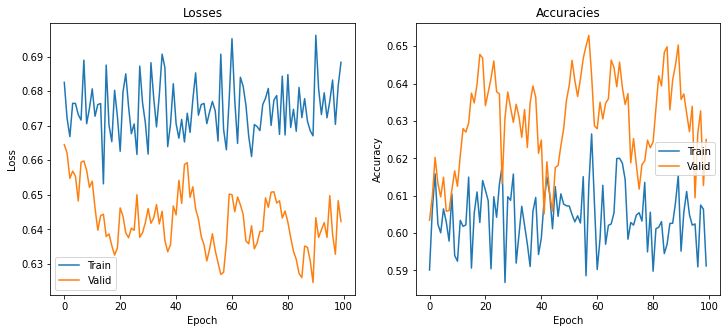

In [75]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

In [72]:
torch.save(model_alexnet.state_dict(), '../models/AlexNet.pt')

def save_checkpoint(model, optimizer, save_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, save_path)

save_path = '../models/AlexNet2.pt'
save_checkpoint(model_alexnet, optimizer, save_path = save_path)

In [73]:
PATH = '../models/AlexNet.pt'
model_svd = torch.load(PATH)
model_alexnet.load_state_dict(model_svd)

predictions, labels = test_model(model_alexnet, test_loader)

Test Accuracy: 57.27%
Confusion Matrix:
[[10 10]
 [ 1  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.50      0.65        20
           1       0.09      0.50      0.15         2

    accuracy                           0.50        22
   macro avg       0.50      0.50      0.40        22
weighted avg       0.83      0.50      0.60        22



### Section 3.2. Pre-trained VGG16 Model for Binary Classification Task

Similar to <code>AlexNet</code>, we changed the last fully connected layer of the <code>VGG16</code> with 2 output channels to make the model suitable for a binary classification task. The modified <code>VGG16</code> has only 8194 parameters. We hypothesized that modified <code>VGG16</code> will generate lower performance metrics than <code>SamuelNet</code> given its number of parameters.

In [44]:
model_vgg16 = torchvision.models.vgg16(weights = True).to(device)

for param in model_vgg16.parameters():
    param.requires_grad = False

torch.manual_seed(42)
model_vgg16.classifier[-1] = torch.nn.Linear(4096, 2)

count_parameters(model_vgg16, print_all = False)

________
    8194


The performance of the pretrained VGG16 model appears to be poor, as both the training and validation accuracies are low and fluctuating over the epochs. The training accuracy starts from 0.51 and reaches a maximum of 0.54 after 40 epochs, while the validation accuracy starts from 0.52 and reaches a maximum of 0.54 after 40 epochs. These values suggest that the model is not overfitting or underfitting, but rather has limited capacity to learn from the data. Additionally, the loss values are high, indicating that the model is not able to minimize the errors effectively. The training loss starts from 0.74 and drops to 0.72 after 60 epochs, while the validation loss starts from 0.76 and drops to 0.73 after 60 epochs.

The training and validation process took 85 minutes using the local device.

In [82]:
train_losses_vgg16, valid_losses_vgg16, train_accurs_vgg16, valid_accurs_vgg16, test_loss_vgg16, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric_vgg16, test_predictions, best_model = train(100, model_vgg16, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.74251   	 Accuracy: 0.51163 	 Validation Loss  0.76348 	 Accuracy: 0.51919
Epoch: 11 	 Training: Loss 0.73454   	 Accuracy: 0.51182 	 Validation Loss  0.75898 	 Accuracy: 0.52367
Epoch: 21 	 Training: Loss 0.73252   	 Accuracy: 0.52377 	 Validation Loss  0.77565 	 Accuracy: 0.49529
Epoch: 31 	 Training: Loss 0.7385   	 Accuracy: 0.51099 	 Validation Loss  0.73743 	 Accuracy: 0.54026
Epoch: 41 	 Training: Loss 0.72036   	 Accuracy: 0.54307 	 Validation Loss  0.76365 	 Accuracy: 0.51731
Epoch: 51 	 Training: Loss 0.73885   	 Accuracy: 0.51802 	 Validation Loss  0.7411 	 Accuracy: 0.53775
Epoch: 61 	 Training: Loss 0.73394   	 Accuracy: 0.51253 	 Validation Loss  0.73355 	 Accuracy: 0.54161
Epoch: 71 	 Training: Loss 0.73739   	 Accuracy: 0.51342 	 Validation Loss  0.75993 	 Accuracy: 0.52094
Epoch: 81 	 Training: Loss 0.73399   	 Accuracy: 0.51828 	 Validation Loss  0.75519 	 Accuracy: 0.52529
Epoch: 91 	 Training: Loss 0.73768   	 Accuracy: 0.50837 	 Validati

In [83]:
torch.save(model_vgg16.state_dict(), '../models/VGG16_ver1.pt')

save_path = '../models/VGG16_ver2.pt'
save_checkpoint(model_vgg16, optimizer, save_path = save_path)

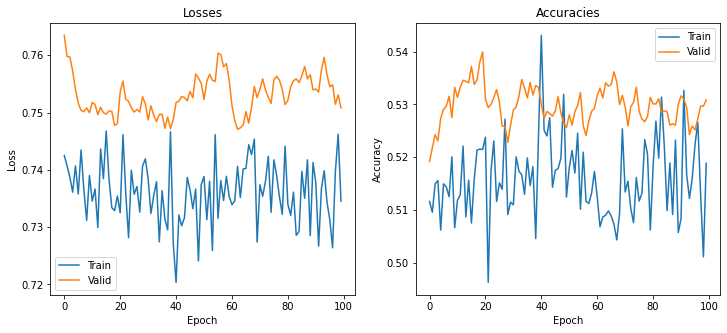

In [84]:
plot_metrics(train_losses_vgg16, valid_losses_vgg16, train_accurs_vgg16, valid_accurs_vgg16)

In [85]:
PATH = '../models/VGG16_ver1.pt'
model_svd = torch.load(PATH)
model_vgg16.load_state_dict(model_svd)

predictions, labels = test_model(model_vgg16, test_loader)

Test Accuracy: 58.01%
Confusion Matrix:
[[10 10]
 [ 1  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.50      0.65        20
           1       0.09      0.50      0.15         2

    accuracy                           0.50        22
   macro avg       0.50      0.50      0.40        22
weighted avg       0.83      0.50      0.60        22



**The frozen AlexNet and VGG16 produced poor model performance and classification metrics.** As seen in the loss function plots, AlexNet and VGG16 generated high training loss and a high validation loss that do not decrease much over time. This scenario causes underfitting where both models aren't able to capture the relevant features since AlexNet and VGG16 have insufficient model complexity - especially to the number of parameters. **Recall that pre-trained AlexNet and VGG16 has more than 60 million and 138 million parameters, respectively. Because we froze its parameters, its remaining parameters became 120,000 and 8,000 weights, respectively.**

Aside from the experiments above, we simulated PyTorch's AlexNet, VGG16, and DenseNet with varying number of parameters on GoogleColab. Unfortunately, they all produced either underfitting due to small number of parameters in their features and classifiers. We also tried using these pre-trained models with frozen parameters on their classifier, but it also produced underfitting.   

### Section 3.3. Pre-trained DenseNet Model for Binary Classification Task

In [58]:
class BinaryDenseNet(nn.Module):
    def __init__(self):
        super(BinaryDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        for param in self.densenet.features.parameters():
            param.requires_grad = False
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, 2)
        
    def forward(self, x):
        x = self.densenet(x)
        return x

model_densenet = models.densenet121(pretrained = True)
count_parameters(model_densenet, print_all = False)

________
 7978856


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_densenet.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_densenet, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.88891   	 Accuracy: 0.69632 	 Validation Loss  0.59477 	 Accuracy: 0.70682
Epoch: 2 	 Training: Loss 0.52521   	 Accuracy: 0.75 	 Validation Loss  0.60884 	 Accuracy: 0.70633
Epoch: 3 	 Training: Loss 0.54242   	 Accuracy: 0.75697 	 Validation Loss  0.48093 	 Accuracy: 0.786
Epoch: 4 	 Training: Loss 0.46235   	 Accuracy: 0.79333 	 Validation Loss  0.44951 	 Accuracy: 0.77009
Epoch: 5 	 Training: Loss 0.42624   	 Accuracy: 0.81122 	 Validation Loss  0.42706 	 Accuracy: 0.82259
Epoch: 6 	 Training: Loss 0.41001   	 Accuracy: 0.81499 	 Validation Loss  0.47243 	 Accuracy: 0.78771
Epoch: 7 	 Training: Loss 0.37833   	 Accuracy: 0.84024 	 Validation Loss  0.44337 	 Accuracy: 0.82039
Epoch: 8 	 Training: Loss 0.54193   	 Accuracy: 0.73588 	 Validation Loss  0.53659 	 Accuracy: 0.74036
Epoch: 9 	 Training: Loss 0.6014   	 Accuracy: 0.72776 	 Validation Loss  1.29857 	 Accuracy: 0.75359
Epoch: 10 	 Training: Loss 0.47198   	 Accuracy: 0.78905 	 Validation Loss  0.9

Let's plot the training and validation metrics of the DenseNet at 100 epochs. As seen below, there are clear signs of overfitting - as seen in the increasing gap during epoch 6 onwards, and the sharp increase of validation loss during epoch 26. This suggests that the model is fitting too closely to the training data and not generalizing well to new data. We can solve this by adding regularization techniques, such as dropout, or early stopping could be applied to address this.

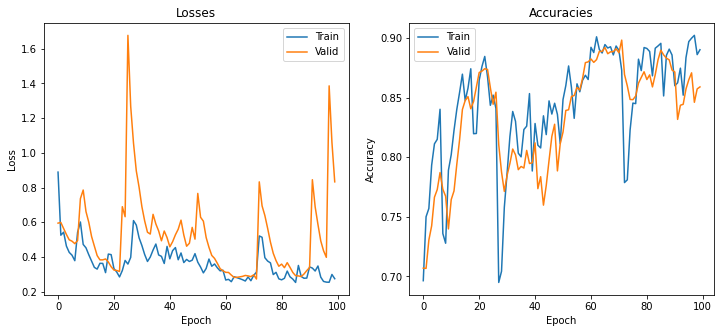

In [68]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

Try to plot the losses and accuracies until 25th epoch. We should have utilized Early Stopping that allows us to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset. In this case, we utilized epoch 100 and have found out that we can get the good trained model only at 25 epochs. Unfortunately, oscillatory patterns can still be seen in the plot below as potential signs of model overfitting. Another way to improve this is to add regularization techniques such as dropouts.

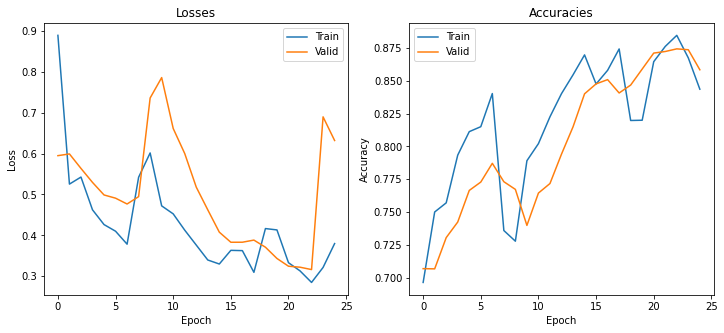

In [69]:
plot_metrics(train_losses[:25], valid_losses[:25], train_accurs[:25], valid_accurs[:25])

Evaluate the DenseNet-121 model on testing dataset. The <code>Without nodule</code> class generated high F1-score, suggesting that DenseNet-121 has a high precision and recall in predicting samples that do not have nodules. This suggests that the model is good at correctly identifying instances that do not have nodules, has low false positive, and false negative rates. On one hand, the F1-score for <code>With nodule</code> class suggests that DenseNet-121 is not as good at predicting instances that have nodules. This could be due to class imbalance or the model being biased towards the "Without nodule" class.

In [67]:
predictions, labels = test_model(model_densenet, test_loader)

Test Accuracy: 85.64%
Confusion Matrix:
[[16  4]
 [ 0  2]]
Classification Report:
                precision    recall  f1-score   support

Without nodule       1.00      0.80      0.89        20
   With nodule       0.33      1.00      0.50         2

      accuracy                           0.82        22
     macro avg       0.67      0.90      0.69        22
  weighted avg       0.94      0.82      0.85        22



Let's try to use the <code>best_model</code> of DenseNet, which was evaluated at epoch 72. In this way, we can see that it can generate higher classification metrics. 

In [66]:
predictions, labels = test_model(best_model, test_loader)

Test Accuracy: 92.29%
Confusion Matrix:
[[18  2]
 [ 0  2]]
Classification Report:
                precision    recall  f1-score   support

Without nodule       1.00      0.90      0.95        20
   With nodule       0.50      1.00      0.67         2

      accuracy                           0.91        22
     macro avg       0.75      0.95      0.81        22
  weighted avg       0.95      0.91      0.92        22



## Section 4. Improving SamuelNet

We improved SamuelNet, now dubbed as <code>ModifiedSamuelNet</code>, to provide more generability to new samples in our dataset and avoid any potential signs of either underfitting or overfitting. The <code>ModifiedSamuelNet</code> was revised based on the number of parameters and results from SamuelNet, AlexNet, VGG16, and DenseNet. Recall that SamuelNet has 1.6 million parameters, while pre-trained AlexNet and VGG16 were utilized with frozen parameters of 120,000 and 8,000 weights, respectively. We initially assume that using a CNN model with lower number of weights, with the appropriate feature extraction convolutions, can provide good classification performance and can generalize well to unseen data. However, results from AlexNet and VGG16 were poor and underfitting. We decided to utilize pre-trained DenseNet with 7 million parameters to check whether higher number of parameters can generate good performance. Unfortunately, DenseNet model suffers from overfitting. We can resolve this issue by implementing the EarlyStopping technique, which allowed us to train the DenseNet with a lower number of epochs. **Based on these findings, we concluded that adding complexity (parameters 1.6 million $\leq$ x $\leq$ 7 million) to SamuelNet's feature extraction layers and classifiers could improve its performance.** Specifically, we added more complexity to these layers by introducing additional convolutional layers and FC networks. The resulting ModifiedSamuelNet showed significant improvement in performance and generalizability on our dataset.

We used a higher number of channels in the convolutional layer to allow our network to learn more complex features. When the number of channels is increased, the network can learn a more diverse set of filters that can capture a wider range of image features. This can lead to better discrimination between different classes of images, and ultimately, better performance on the binary classification. However, increasing the number of channels also comes with a trade-off: it increases the computational complexity of the network, which can increase the training time and require more computational resources. This might lead to overfitting. Therefore, we added 2 dropout layers in our model - one in the feature extraction module and one dropout in the classifier part. Dropout works by randomly dropping out (setting to zero) some of the neurons in a neural network during training. This forces the network to learn redundant representations of the data, which can make it more robust to noise and variations in the input data. By doing so, dropout reduces the reliance of the network on any one specific set of neurons, thus preventing overfitting and improving generalization performance.

The number of parameters has also increased - from the original 1.6 million parameters into 6.76 million parameters. 

In [30]:
class ModifiedSamuelNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  64,  3, 1, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, padding = 1)

        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,   2)
        
        self.dropout = nn.Dropout(p = 0.3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
count_parameters(ModifiedSamuelNet(), print_all = True)

    1728
      64
   73728
     128
 6553600
     512
  131072
     256
     512
       2
      64
      64
     128
     128
________
 6761986


### Section 4.1 ModifiedSamuelNet Training and Validation

We utilized the same loss functions and optimizer from the SamuelNet. The ModifiedSamuelNet is trained for 100 epochs and is expected to improve its classification performance against SamuelNet. 

In [11]:
model_cnn = ModifiedSamuelNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.76891   	 Accuracy: 0.60219 	 Validation Loss  0.6086 	 Accuracy: 0.71615
Epoch: 11 	 Training: Loss 0.56413   	 Accuracy: 0.68884 	 Validation Loss  0.50594 	 Accuracy: 0.73597
Epoch: 21 	 Training: Loss 0.51056   	 Accuracy: 0.73837 	 Validation Loss  0.50641 	 Accuracy: 0.7656
Epoch: 31 	 Training: Loss 0.45241   	 Accuracy: 0.78898 	 Validation Loss  0.4589 	 Accuracy: 0.79761
Epoch: 41 	 Training: Loss 0.42384   	 Accuracy: 0.7985 	 Validation Loss  0.45733 	 Accuracy: 0.80219
Epoch: 51 	 Training: Loss 0.38302   	 Accuracy: 0.82924 	 Validation Loss  0.37306 	 Accuracy: 0.85155
Epoch: 61 	 Training: Loss 0.3821   	 Accuracy: 0.83206 	 Validation Loss  0.38037 	 Accuracy: 0.85317
Epoch: 71 	 Training: Loss 0.36039   	 Accuracy: 0.84861 	 Validation Loss  0.44389 	 Accuracy: 0.82716
Epoch: 81 	 Training: Loss 0.3554   	 Accuracy: 0.84286 	 Validation Loss  0.35012 	 Accuracy: 0.84918
Epoch: 91 	 Training: Loss 0.32135   	 Accuracy: 0.86484 	 Validation L

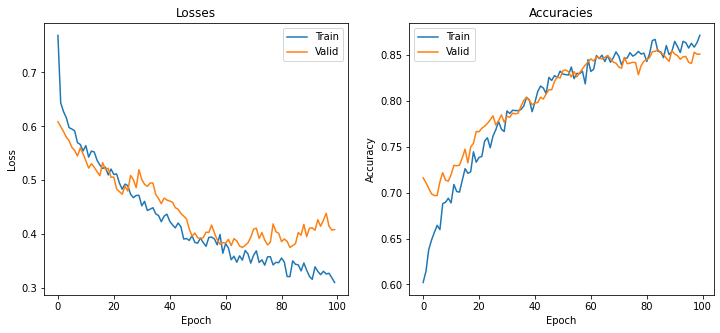

In [21]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

The evaluation of the ModifiedSamuelNetwork model suggests that it has achieved good performance on the given dataset. The high accuracy, precision, recall, and F1-score of the model indicate that it has successfully learned to discriminate between the two classes, despite the imbalanced nature of the data. The model achieved a high accuracy of 0.95, indicating that it correctly classified 95% of the samples. The precision of class 0 was 1.00, indicating that all of the samples classified as class 0 by the model were truly members of that class. The recall of class 1 was 1.00, indicating that the model correctly identified all samples belonging to class 1. However, the precision of class 1 was lower than class 0, indicating some room for improvement.

 The precision of class 0 is 1.00, indicating that all of the samples classified as class 0 by the model were truly members of that class. The precision of class 1 is 0.67, indicating that 1 out of the 3 samples classified as class 1 by the model were misclassified. The recall of class 0 is 0.95, indicating that the model correctly identified 95% of the samples belonging to class 0. The recall of class 1 is 1.00, indicating that the model correctly identified all samples belonging to class 1.

 It is noteworthy that the dataset was imbalanced, with a significantly larger number of samples in class 0 compared to class 1. Imbalanced datasets can present a challenge for machine learning models, as they tend to bias the model towards the majority class. However, the ModifiedSamuelNetwork model was able to achieve good performance despite the imbalanced nature of the data. This may be attributed to the use of appropriate techniques for handling imbalanced data, such as stratified sampling, data augmentation, and adjusting the classification threshold. Additionally, the architecture of the model may have played a role, as it was designed not to be deep and complex, but just at the right complexity with multiple convolutional and fully connected layers, which can help the model learn more discriminative features and patterns in the data. Overall, the evaluation of the model suggests that it is capable of effectively handling imbalanced datasets and achieving good performance on classification tasks.

In [ ]:
PATH = '../models/ModifiedSamNetwork.pt'
torch.save(model_cnn.state_dict(), PATH)

### Section 4.2 ModifiedSamuelNet Inference and Testing

Let's test the pre-trained ModifiedSamuelNet on a single batch of train_loader. 

In [18]:
PATH = '../models/ModifiedSamNetwork.pt'

model_cnn = ModifiedSamuelNet()
model_svd = torch.load(PATH)
model_cnn.load_state_dict(model_svd)

predictions, labels = test_model(model_cnn, test_loader)

Test Accuracy: 90.57%
Confusion Matrix:
[[19  1]
 [ 0  2]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.67      1.00      0.80         2

    accuracy                           0.95        22
   macro avg       0.83      0.97      0.89        22
weighted avg       0.97      0.95      0.96        22



Results have shown that it has greatly improved its classification performance on unseen dataset. The <code>Without nodule</code> class (label 0) produced a 97% F1-score while 0.80% for the <code>With nodule</code> class (label 1). These results implies that the ModifiedSamuelNet's precision and recall both perform reasonably well, and that the overall accuracy of the model's predictions is also good. Let's try using the trained weights of ModifiedSamuelNet to more unseen data! 

As shown below, we can also imply that the ModifiedSamuelNet is performing significantly better at predicting the <code>Without nodule</code> class (label 0), as it has an F1-score of 0.96. This suggests that the model is very good at identifying samples that do not contain nodules. On the other hand, the <code>With nodule</code> class has a lower F1-score of 0.74, indicating that the model is moderately performing as well in predicting samples that contain nodules. This means that the ModifiedSamuelNet has high chance of making more errors in identifying nodules in samples, leading to a lower F1-score. In addition, **ModifiedSamuelNet may not be a good predictor of nodules for patients who are at higher risk of having nodules, such as those with a family history of nodules or prior nodules.** The lower F1-score for the <code>With Nodule</code> class may indicate a limitation in the model's ability to detect nodules in patients who already have them, and this could impact the overall usefulness of the model for predicting nodules in patients who are at higher risk of having nodules.

In [34]:
predictions, labels = test_model(model_cnn, test_loader)

Test Accuracy: 90.57%
Confusion Matrix:
[[100   5]
 [  4  13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       105
           1       0.72      0.76      0.74        17

    accuracy                           0.93       122
   macro avg       0.84      0.86      0.85       122
weighted avg       0.93      0.93      0.93       122



### Section 4.3 ModifiedSamuelNet: Checking Misclassifications

Let's try to evaluate the <code>ModifiedSamuelNet</code> to a batch of test loader. As seen below, a single input image with index 17 generated a misclassification.

In [20]:
misses = np.array([])
for i in range(len(predictions.view(-1))):
    if predictions[i] != labels[i]:
        misses = np.append(misses,i).astype('int64')

r = 12 
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
print("Index:", nextrow)
print("Label:", labels.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predictions.index_select(0,torch.tensor(nextrow)).numpy())

Index: [17]
Label: [0]
Guess: [1]


In [35]:
misses = np.array([])
for i in range(len(predictions.view(-1))):
    if predictions[i] != labels[i]:
        misses = np.append(misses,i).astype('int64')

r = 12 
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
print("Index:", nextrow)
print("Label:", labels.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predictions.index_select(0,torch.tensor(nextrow)).numpy())

Index: [ 17  34  35  65  76  82  86  98 117]
Label: [0 1 1 0 1 1 0 0 0]
Guess: [1 0 0 1 0 0 1 1 1]


Let's try another batch of input images in our test_loader. 

Label: [0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
Guess: [1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]


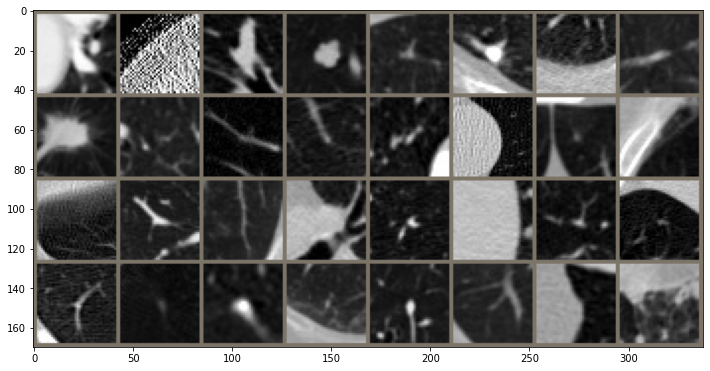

In [21]:
for idx, (image, label) in enumerate(test_loader):
    if idx == 5:
        break
predict = model_cnn(image)
_, out = torch.max(predict, 1)

print("Label:", label.numpy())
print("Guess:", out.numpy())

im = make_grid(image, nrow = 8) 
inv_normalize = transforms.Normalize(
                    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std  = [1/0.229, 1/0.224, 1/0.225])
im_inv = inv_normalize(im)
plt.figure(figsize = (12, 7))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))